# Kelly Criteriom
## Use Index of representative asset classes
#### Developed-Emerging Equity, Real Estate, Commmodity, Treasury, Corporate Bond, TIPS are included
#### Result is driven from 2010 to 2021 market data

#### Kelly rule has a long history in gambling because it provides guidance on how much to stake on each of an (infinite) sequence of bets with varying (but favorable) odds to maximize terminal wealth. It was published as A New Interpretation of the Information Rate in 1956 by John Kelly who was a colleague of Claude Shannon's at Bell Labs. He was intrigued by bets placed on candidates at the new quiz show The $64,000 Question, where a viewer on the west coast used the three-hour delay to obtain insider information about the winners.

#### Kelly drew a connection to Shannon's information theory to solve for the bet that is optimal for long-term capital growth when the odds are favorable, but uncertainty remains. His rule maximizes logarithmic wealth as a function of the odds of success of each game, and includes implicit bankruptcy protection since log(0) is negative infinity so that a Kelly gambler would naturally avoid losing everything.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import numpy as np
import pandas as pd

import quantstats

from sympy import symbols, solve, log, diff

from utils.yahoo_stock_data import yahoo_data
from utils.regular_rebalancing import rebalance_strategy

#### Kelly began by analyzing games with a binary win-lose outcome. The key variables are:,
- b: The odds define the amount won for a \$1 bet.
  (odds = 5/1  implies a 5 dollars gain if the bet wins, plus recovery of the 1 dollar capital)
- p: The probability defines the likelihood of a favorable outcome.,
- f: The share of the current capital to bet.
- V: The value of the capital as a result of betting.

#### The Kelly rule aims to maximize the value's growth rate, G, of infinitely-repeated bets :

$ G=\\lim_{N\\rightarrow\\infty}=\\frac{1}{N}\\log\\frac{V_N}{V_0} $


In [7]:
share, odds, probability = symbols('share odds probability')
Value = probability * log(1 + odds * share) + (1 - probability) * log(1 - share)
solve(diff(Value, share), share)


[(odds*probability + probability - 1)/odds]

In [8]:
f, p = symbols('f p')
y = p * log(1 + f) + (1 - p) * log(1 - f)
solve(diff(y, f), f)

[2*p - 1]

## Kelly Rule for Multiple Assets
#### We will use an example with various equities. E. Chan (2008) illustrates how to arrive at a multi-asset application of the Kelly Rule, and that the result is equivalent to the (potentially levered) maximum Sharpe ratio portfolio from the mean-variance optimization.

#### The computation involves the dot product of the precision matrix, which is the inverse of the covariance matrix, and the return matrix:


In [9]:
def kelly_allocation_mp(asset_ylds):
    cov = asset_ylds.cov()
    precision_matrix = pd.DataFrame(np.linalg.inv(cov), index=asset_ylds.columns.tolist(), columns=asset_ylds.columns.tolist())
    # np.linalg.inv(cov) returns inverse matrix in numpy matrix type
    kelly_allocation = asset_ylds.mean().dot(precision_matrix)
    kelly_allocation[kelly_allocation < 0] = 0
    kelly_allocation = kelly_allocation.div(kelly_allocation.sum())
    # kelly_allocation.sort_values(ascending=False).plot.barh(figsize=(8, 10))
    # plt.yticks(fontsize=12)
    # sns.despine()
    # plt.tight_layout()

    return kelly_allocation

In [76]:
def monthly_rebalance_strategy(yld_df, bm_yld_df):
    yld_df_12m = yld_df.resample('1M').first()
    bm_yld_df_12m = bm_yld_df.resample('1M').first()

    KL_weight = []

    for i in range(len(yld_df_12m)):
        if i < 3:
            KL_weight.append("")
        else:
            KL_weight.append(kelly_allocation_mp(yld_df_12m.iloc[i-3:i-1]).tolist())

    yld_df_12m['KL_Weight'] = KL_weight
    # rebalance portfolio every 12 month, thus first 12 month cannot make position
    yld_df_12m = yld_df_12m.iloc[3: ,:]

    KL_Return = []
    ret = 0
    for i in range(len(yld_df_12m)):
        # investment return of asset class * weight of asset class
        for j in range(yld_df_12m.shape[1]-1):
            ret += (yld_df_12m.iloc[i,j]) * ((yld_df_12m['KL_Weight'].iloc[i])[j])

        KL_Return.append(ret)
        ret = 0

    yld_df_12m['KL_Return'] = KL_Return
    yld_df_12m['BM_Return'] = bm_yld_df_12m

    return yld_df_12m

In [77]:
def weekly_rebalance_strategy(yld_df, bm_yld_df):
    yld_df_52w = yld_df.resample('1W').first()
    bm_yld_df_52w = bm_yld_df.resample('1W').first()
    KL_weight = []

    for i in range(len(yld_df_52w)):
        if i < 8:
            KL_weight.append("")
        else:
            KL_weight.append(kelly_allocation_mp(yld_df_52w.iloc[i-9:i-1]).tolist())

    yld_df_52w['KL_Weight'] = KL_weight
    # rebalance portfolio every week, first 4 weeks cannot make position
    yld_df_52w = yld_df_52w.iloc[8: , :]

    KL_Return = []
    ret = 0
    for i in range(len(yld_df_52w)):
        # investment return of asset class * weight of asset class
        for j in range(yld_df_52w.shape[1]-1):
            ret += (yld_df_52w.iloc[i,j]) * ((yld_df_52w['KL_Weight'].iloc[i])[j])

        KL_Return.append(ret)
        ret = 0

    yld_df_52w['KL_Return'] = KL_Return
    yld_df_52w['BM_Return'] = bm_yld_df_52w

    return yld_df_52w

### Load Data of each asset classes
##### Use representative ETF to model strategy
##### Data should be in yld format [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price]

In [10]:
asset_class_ticker =[
    "IVV",  # iShares Core S&P 500 ETF                              2000-05-15
    "VEA",  # Vanguard FTSE Developed Markets ETF                    2007-07-02
    "VWO",  # Vanguard FTSE Emerging Markets ETF                    2005-03-04
    "TLT",  # iShares 20+ Year Treasury Bond ETF                    2002-07-22
    "TIP",  # iShares TIPS Bond ETF                                 2003-12-04
    "LQD",  # iShares iBoxx $ Investment Grade Corporate Bond ETF   2002-07-22
    "DBC",  # Invesco DB Commodity Index Tracking Fund              2006-02-03
    "XAR",  # SPDR® S&P® Aerospace & Defense ETF                    2011-09-28
    "XLB",  # The Materials Select Sector SPDR® Fund                1998-12-16
    "XLE",  # The Energy Select Sector SPDR® Fund                   1998-12-22
    "XLF",  # The Financial Select Sector SPDR® Fund                1998-12-22
    "XLI",  # The Industrial Select Sector SPDR® Fund               1998-12-22
    "XLK",  # The Technology Select Sector SPDR® Fund               1998-12-22
    "XME",  # SPDR® S&P® Metals & Mining ETF                        2006-06-23
    "XLP",  # The Consumer Staples Select Sector SPDR® Fund         1998-12-22
    "XLY",  # The Consumer Discretionary Select Sector SPDR® Fund   1998-12-22
    "XLU",  # The Utilities Select Sector SPDR® Fund                1998-12-22
    "XLV",  # The Health Care Select Sector SPDR® Fund              1998-12-22
    "XPH",  # SPDR® S&P® Pharmaceuticals ETF                        2006-06-22
    "XBI",  # SPDR® S&P® Biotech ETF                                2006-02-06
    "RWR",  # SPDR® Dow Jones® REIT ETF                             2001-04-23
    "RWX"   # SPDR® Dow Jones® International Real Estate ETF        2006-12-15
]

bm_class_ticker =[
    "VTI", # Vanguard Total Stock Market ETF                        2001-05-24
    "TLT", # iShares 20+ Year Treasury Bond ETF                     2002-07-22
    "IEI", # iShares 3-7 Year Treasury Bond ETF                     2007-01-05
    "GLD", # SPDR Gold Trust                                        2004-11-18
    "GSG"  # iShares S&P GSCI Commodity Indexed Trust               2006-07-10
                    ]

In [11]:
# for monthly rebalance strategy
data_setting = {
    'start' : '2013-02-01',
    'end' : '2022-02-01',
    'ticker_list': asset_class_ticker,
    'rebal_period' : '1M',
}

data = yahoo_data(**data_setting)
yield_df = data.yahoo_stock_data_loading()
yield_df

# to draw benchmark
data_setting = {
    'start' : '2013-02-01',
    'end' : '2022-02-01',
    'ticker_list': bm_class_ticker,
    'rebal_period' : '1M',
}

data = yahoo_data(**data_setting)
benchmark_yield_df = data.yahoo_stock_data_loading()
benchmark_yield_df['BM'] = (0.3*benchmark_yield_df.loc[:,'VTI'] +
                            0.4*benchmark_yield_df.loc[:,'TLT'] +
                            0.15*benchmark_yield_df.loc[:,'IEI'] +
                            0.075*benchmark_yield_df.loc[:,'GLD'] +
                            0.075*benchmark_yield_df.loc[:,'GSG']
                            )

In [15]:
monthly_rebal_strategy = rebalance_strategy(strategy=kelly_allocation_mp, yld_df=yield_df, bm_yld_df=benchmark_yield_df['BM'], lookback_period=4)
monthly_rebal_strategy

,strategy_return,benchmark_return,IVV,VEA,VWO,TLT,TIP,LQD,DBC,XAR,...,XME,XLP,XLY,XLU,XLV,XPH,XBI,RWR,RWX,SUM
Date,,,,,,,,,,,,,,,,,,,,,
2013-06-30,0.034398,-0.020255,0.0,0.0,0.0661,0.0,0.0,0.041801,0.0,0.153679,...,0.045765,0.0,0.02131,0.019533,0.0,0.0,0.091432,0.0,0.087879,1.0
2013-07-31,-0.032519,-0.028336,0.013749,0.056238,0.0,0.092322,0.419628,0.0,0.007895,0.0,...,0.033454,0.04508,0.0,0.006416,0.0,0.001094,0.0,0.0,0.0,1.0
2013-08-31,0.053139,0.008935,0.0,0.032169,0.015065,0.0,0.122945,0.0,0.0,0.0,...,0.0,0.040686,0.443544,0.0,0.029046,0.0,0.0,0.0,0.045855,1.0
2013-09-30,-0.032251,-0.006662,0.0,0.067784,0.0,0.0,0.11558,0.0,0.0,0.0,...,0.050458,0.0,0.210874,0.117023,0.04353,0.0,0.171611,0.0,0.0,1.0
2013-10-31,0.037673,0.010271,0.091678,0.00506,0.0,0.0,0.299419,0.015723,0.0,0.0,...,0.071011,0.0,0.074473,0.0,0.025556,0.17317,0.0,0.0,0.131084,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31,-0.007886,-0.016478,0.0,0.010149,0.0,0.0,0.154292,0.278978,0.136159,0.102805,...,0.0,0.099553,0.0,0.037712,0.066411,0.026144,0.021255,0.0,0.015036,1.0
2021-11-30,0.044273,0.024761,0.318699,0.0,0.0,0.0,0.293855,0.0,0.0,0.044092,...,0.05233,0.0,0.064904,0.0,0.0,0.013233,0.006643,0.084161,0.0,1.0
2021-12-31,-0.041995,-0.002739,0.00368,0.0,0.0,0.088282,0.0,0.181069,0.025983,0.116939,...,0.0,0.0,0.0,0.100776,0.019175,0.200677,0.062843,0.026586,0.0,1.0


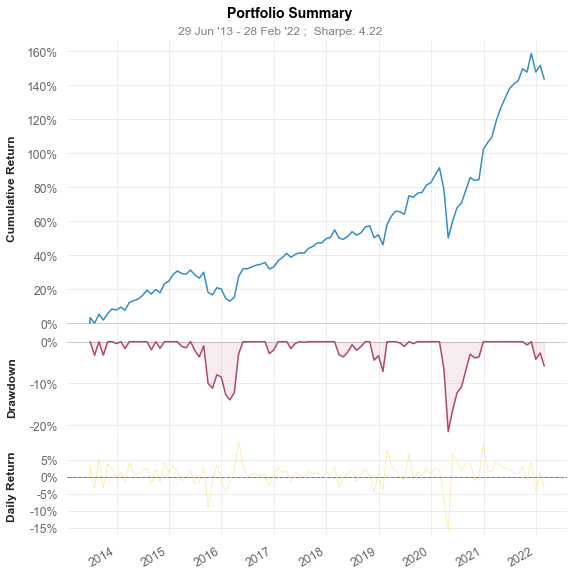

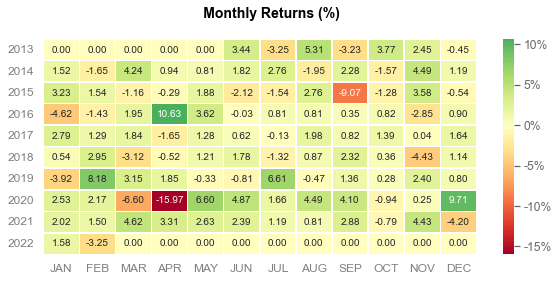

In [19]:
quantstats.reports.plots(returns = monthly_rebal_strategy.loc[ : , 'strategy_return'],benchmark = monthly_rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

In [20]:
quantstats.reports.metrics(returns = monthly_rebal_strategy.loc[ : , 'strategy_return'],benchmark = monthly_rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2013-06-30  2013-06-30
End Period          2022-02-28  2022-02-28
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   143.67%     75.73%
CAGR﹪              10.82%      6.72%

Sharpe              4.24        4.83
Sortino             6.41        8.36
Sortino/√2          4.54        5.91
Omega               2.12        2.12

Max Drawdown        -21.52%     -6.86%
Longest DD Days     336         488

Gain/Pain Ratio     1.12        1.14
Gain/Pain (1M)      1.12        1.14

Payoff Ratio        0.86        1.02
Profit Factor       2.12        2.14
Common Sense Ratio  2.67        2.6
CPC Index           1.24        1.42
Tail Ratio          1.26        1.21
Outlier Win Ratio   2.85        4.46
Outlier Loss Ratio  2.34        4.41

MTD                 -3.25%      -1.7%
3M                  -1.68%      0.82%
6M                  1.16%       1.95%
Y

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2013-06-30  2013-06-30
End Period                 2022-02-28  2022-02-28
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          143.67%     75.73%
CAGR﹪                     10.82%      6.72%

Sharpe                     4.24        4.83
Smart Sharpe               4.12        4.69
Sortino                    6.41        8.36
Smart Sortino              6.23        8.12
Sortino/√2                 4.54        5.91
Smart Sortino/√2           4.4         5.74
Omega                      2.12        2.12

Max Drawdown               -21.52%     -6.86%
Longest DD Days            336         488
Volatility (ann.)          54.12%      28.94%
R^2                        0.43        0.43
Calmar                     0.5         0.98
Skew                       -1.08       -0.23
Kurtosis                   6.02        0.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-31,2020-04-30,2020-12-31,275,-21.520085,-16.339681
2,2015-06-30,2016-02-29,2016-05-31,336,-13.913624,-12.660862
3,2018-11-30,2019-01-31,2019-02-28,90,-7.128319,-4.427494
4,2021-12-31,2022-02-28,2022-02-28,59,-5.852592,-4.199459
5,2018-03-31,2018-04-30,2018-09-30,183,-3.622681,-3.123434


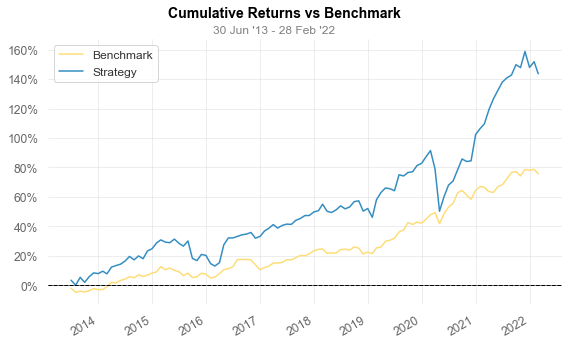

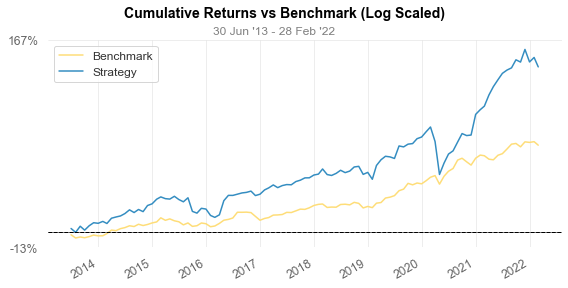

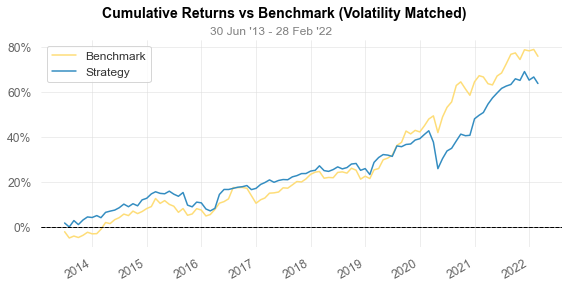

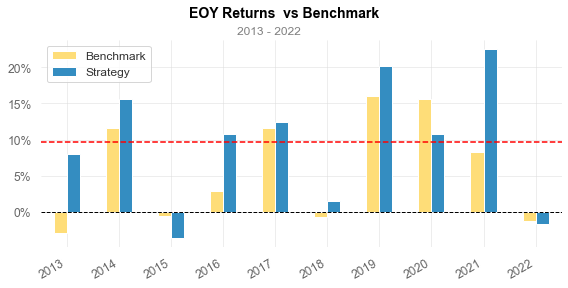

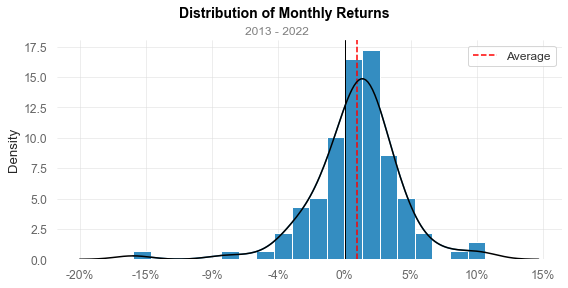

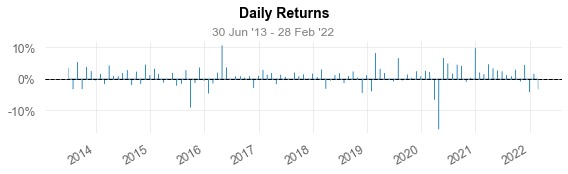

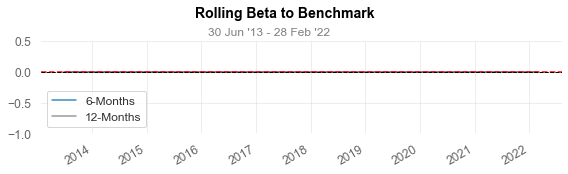

IndexError: index 0 is out of bounds for axis 0 with size 0

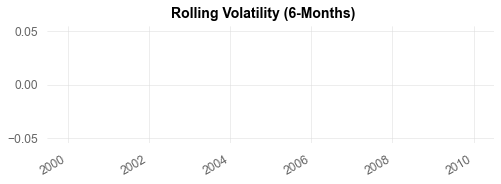

In [21]:
quantstats.reports.full(returns = monthly_rebal_strategy.loc[ : , 'strategy_return'],benchmark = monthly_rebal_strategy.loc[ :, 'benchmark_return'])

In [24]:
# for monthly rebalance strategy
data_setting = {
    'start' : '2013-02-01',
    'end' : '2022-02-01',
    'ticker_list': asset_class_ticker,
    'rebal_period' : '1W',
}

data = yahoo_data(**data_setting)
yield_df = data.yahoo_stock_data_loading()
yield_df

# to draw benchmark
data_setting = {
    'start' : '2013-02-01',
    'end' : '2022-02-01',
    'ticker_list': bm_class_ticker,
    'rebal_period' : '1W',
}

data = yahoo_data(**data_setting)
benchmark_yield_df = data.yahoo_stock_data_loading()
benchmark_yield_df['BM'] = (0.3*benchmark_yield_df.loc[:,'VTI'] +
                            0.4*benchmark_yield_df.loc[:,'TLT'] +
                            0.15*benchmark_yield_df.loc[:,'IEI'] +
                            0.075*benchmark_yield_df.loc[:,'GLD'] +
                            0.075*benchmark_yield_df.loc[:,'GSG']
                            )

In [25]:
weekly_rebal_strategy = rebalance_strategy(strategy=kelly_allocation_mp, yld_df=yield_df, bm_yld_df=benchmark_yield_df['BM'], lookback_period=12)
weekly_rebal_strategy

,strategy_return,benchmark_return,IVV,VEA,VWO,TLT,TIP,LQD,DBC,XAR,...,XME,XLP,XLY,XLU,XLV,XPH,XBI,RWR,RWX,SUM
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-05,0.01225,0.011419,0.0,0.0,0.077633,0.0,0.245368,0.173186,0.0,0.026492,...,0.0,0.08388,0.005049,0.0,0.10778,0.0,0.0,0.0,0.042346,1.0
2013-05-12,0.008917,-0.002040,0.0,0.0,0.0,0.0,0.0,0.090057,0.068755,0.0,...,0.009653,0.045608,0.081388,0.111058,0.0,0.0,0.05931,0.261392,0.0,1.0
2013-05-19,0.002872,-0.008553,0.0,0.126092,0.0,0.120284,0.027028,0.0,0.047369,0.0,...,0.0,0.143173,0.007773,0.131486,0.0,0.0,0.087916,0.09728,0.0,1.0
2013-05-26,0.012585,0.001797,0.015356,0.0,0.066788,0.136813,0.0,0.0,0.0,0.152052,...,0.001343,0.291873,0.0,0.056758,0.0,0.0,0.015267,0.127773,0.0,1.0
2013-06-02,-0.009713,-0.014331,0.0,0.058942,0.0,0.097709,0.0,0.155095,0.048923,0.035049,...,0.018421,0.201675,0.056532,0.0,0.0,0.0,0.087774,0.147836,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-09,0.000066,-0.013930,0.245875,0.068607,0.0,0.0,0.0,0.227066,0.0,0.091359,...,0.058626,0.0,0.0,0.035369,0.0,0.0,0.001212,0.068603,0.0,1.0
2022-01-16,-0.006964,-0.013099,0.0,0.049579,0.11559,0.0,0.0,0.307207,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.060292,0.0,0.0,0.063786,1.0
2022-01-23,-0.006918,-0.009913,0.000562,0.071785,0.0,0.019453,0.205597,0.0,0.122584,0.089879,...,0.0,0.0,0.0,0.0,0.0,0.000827,0.030165,0.0,0.083361,1.0


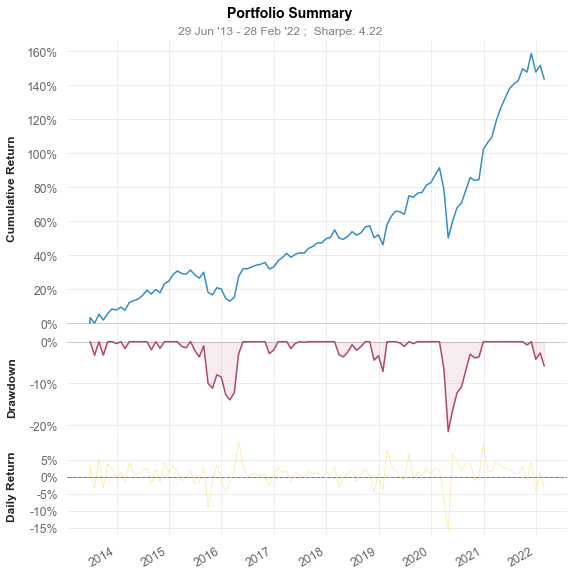

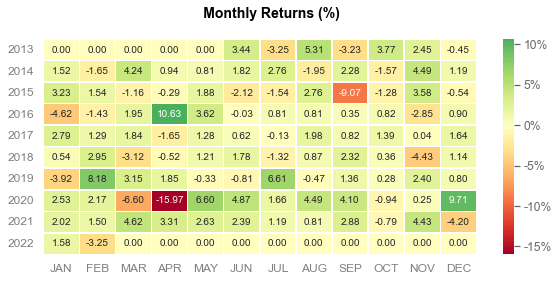

In [26]:
quantstats.reports.plots(returns = monthly_rebal_strategy.loc[ : , 'strategy_return'],benchmark = monthly_rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

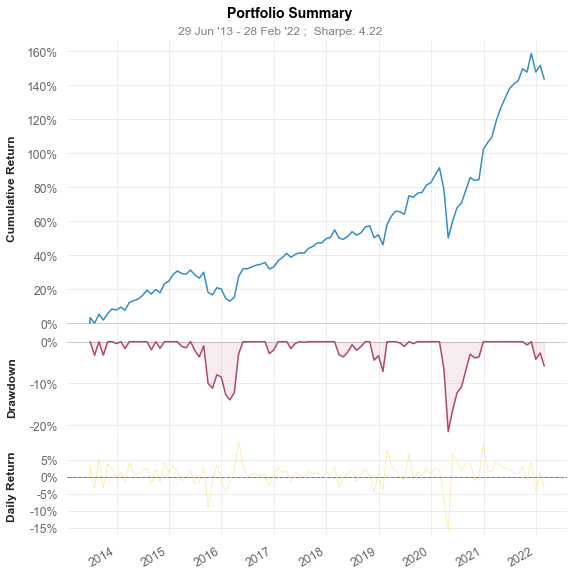

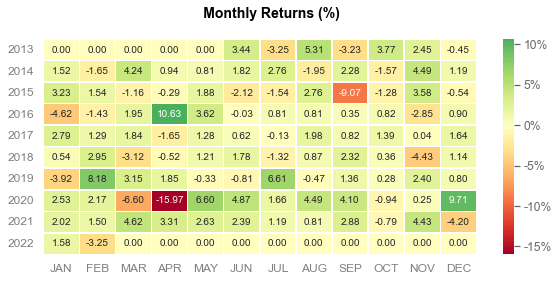

In [27]:
quantstats.reports.plots(returns = monthly_rebal_strategy.loc[ : , 'strategy_return'],benchmark = monthly_rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2013-06-30  2013-06-30
End Period                 2022-02-28  2022-02-28
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          143.67%     75.73%
CAGR﹪                     10.82%      6.72%

Sharpe                     4.24        4.83
Smart Sharpe               4.12        4.69
Sortino                    6.41        8.36
Smart Sortino              6.23        8.12
Sortino/√2                 4.54        5.91
Smart Sortino/√2           4.4         5.74
Omega                      2.12        2.12

Max Drawdown               -21.52%     -6.86%
Longest DD Days            336         488
Volatility (ann.)          54.12%      28.94%
R^2                        0.43        0.43
Calmar                     0.5         0.98
Skew                       -1.08       -0.23
Kurtosis                   6.02        0.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-31,2020-04-30,2020-12-31,275,-21.520085,-16.339681
2,2015-06-30,2016-02-29,2016-05-31,336,-13.913624,-12.660862
3,2018-11-30,2019-01-31,2019-02-28,90,-7.128319,-4.427494
4,2021-12-31,2022-02-28,2022-02-28,59,-5.852592,-4.199459
5,2018-03-31,2018-04-30,2018-09-30,183,-3.622681,-3.123434


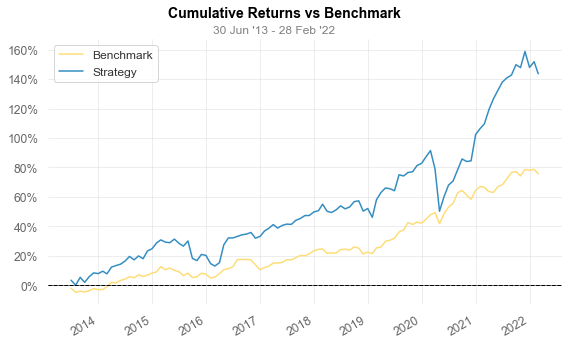

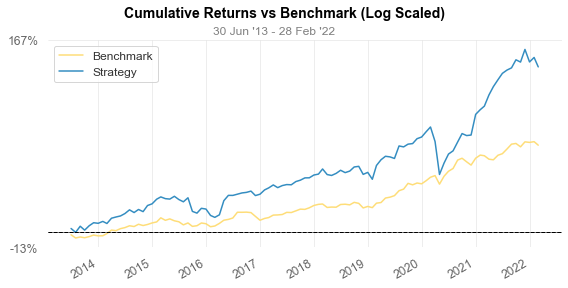

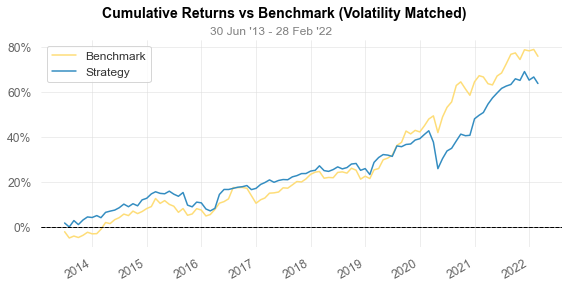

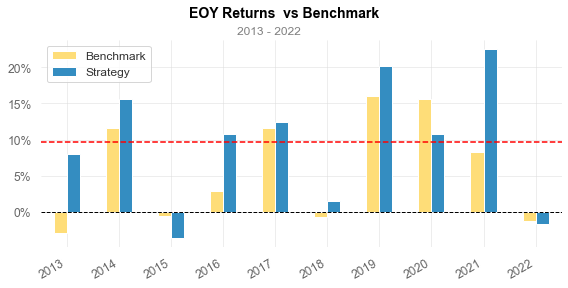

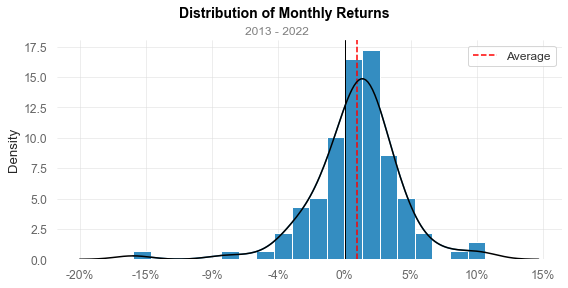

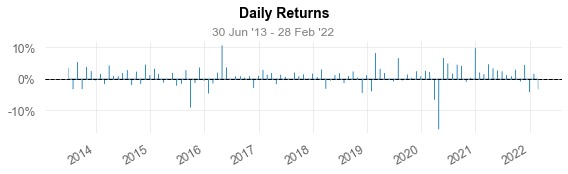

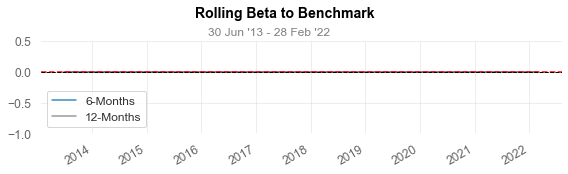

IndexError: index 0 is out of bounds for axis 0 with size 0

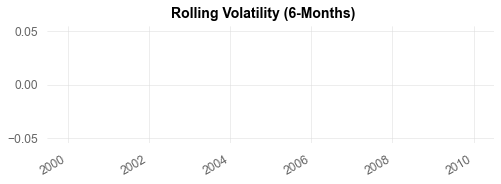

In [28]:
quantstats.reports.full(returns = monthly_rebal_strategy.loc[ : , 'strategy_return'],benchmark = monthly_rebal_strategy.loc[ :, 'benchmark_return'],)